In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set(style="darkgrid")
from scipy import stats
import matplotlib.patches as mpatches

In [2]:
data_types = {'Recall Notification Date': str}
df = pd.read_csv("database.csv", dtype=data_types)

In [3]:
df.dtypes

Record ID                     int64
NHTSA Campaign               object
Manufacturer Campaign        object
Vehicle Make                 object
Vehicle Model                object
Model Year                    int64
Vehicle Manufacturer         object
Recall Type                  object
Recall Component             object
Manufacture Start Date      float64
Manufacture End Date        float64
Estimated Units             float64
Recall Initiative            object
Recall Manufacturer          object
Recall Notification Date     object
dtype: object

In [4]:
toyota_aliases = {
    'TOYOTA MOTOR CO., LTD.',
    'TOYOTA MOTOR NORTH AMERICA, INC.',
    'Toyota Motor Engineering & Manufacturing'
}

In [5]:
toyota_df = df.loc[df['Vehicle Manufacturer'].isin(toyota_aliases)]

In [6]:
toyota_df_over_500k = toyota_df.loc[df['Estimated Units'] > 500000.0]

In [7]:
len(toyota_df_over_500k)

527

In [8]:
toyota_df_filtered = toyota_df_over_500k.dropna(subset=['Recall Notification Date'])

In [9]:
toyota_df_filtered_with_date = toyota_df_filtered['Recall Notification Date'].apply(lambda x:pd.datetime.strptime(x, '%Y%m%d'))

In [10]:
type(toyota_df_filtered['Estimated Units'])

pandas.core.series.Series

In [11]:
date_split_value = pd.datetime(1995, 1, 1) # ignore values before 1995

In [12]:
recalls_by_units_df = pd.DataFrame({
        'Recall Notification Date': toyota_df_filtered_with_date,
        'Estimated Units': toyota_df_filtered['Estimated Units']
})

In [13]:
recalls_by_units_df_after_1995 = recalls_by_units_df.loc[recalls_by_units_df['Recall Notification Date'] > date_split_value]

In [14]:
recalls_by_unit_after_1995_unique = recalls_by_units_df_after_1995.drop_duplicates()

In [15]:
toyota_stock_data_types = {
    'Date': str,
    'Price': float
}
toyota_stock = pd.read_csv('zstock_data_clean/toyota_stock.txt', sep='\t', parse_dates=['Date'])

In [16]:
toyota_stock_after_1995 = toyota_stock.loc[toyota_stock['Date'] > date_split_value]

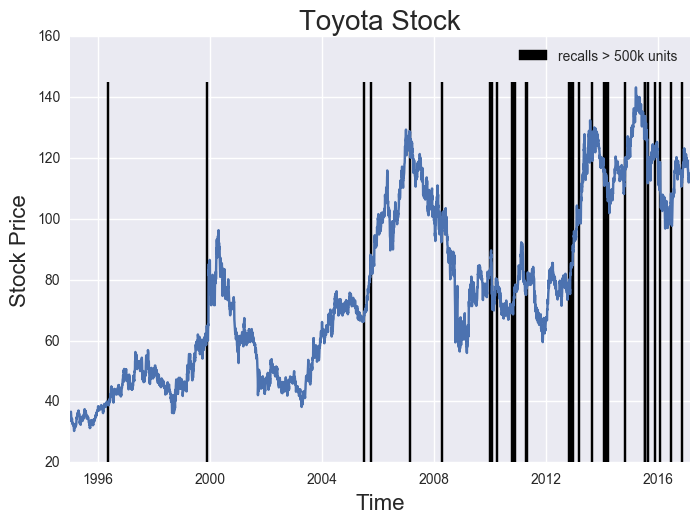

In [17]:
plt.plot(list(toyota_stock_after_1995['Date']), list(toyota_stock_after_1995['Price']))
#plt.scatter(list(recalls_by_unit_after_1995_unique['Recall Notification Date']), [25 for x in range(0, len(recalls_by_unit_after_1995_unique))])
#for i in range(0, len(recalls_by_unit_after_1995_unique))
#    plt.plot([, ])
my_dates_list = list(recalls_by_unit_after_1995_unique['Recall Notification Date'])
plt.vlines(x=my_dates_list, ymin=[20 for x in range(0, len(my_dates_list))], ymax=[145 for x in range(0, len(my_dates_list))])
plt.title('Toyota Stock', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
black_patch = mpatches.Patch(color='black', label='recalls > 500k units')
plt.legend(handles=[black_patch],
           loc='upper right')
plt.show()

In [18]:
type(toyota_stock_after_1995['Date'][5707])

pandas.tslib.Timestamp

In [19]:
toyota_stock_after_1995_reset_indices = toyota_stock_after_1995.reset_index()
toyota_stock_after_1995_reset_indices.drop('index', axis=1, inplace=True)

In [20]:
# now we will conduct the event study
dates_arr = np.array(toyota_stock_after_1995_reset_indices['Date'])
prices_arr = np.array(toyota_stock_after_1995_reset_indices['Price'])
recalls_dates_arr = np.array(recalls_by_unit_after_1995_unique['Recall Notification Date'])

In [21]:
len(dates_arr)

5577

In [22]:
len(recalls_dates_arr)

30

In [23]:
#recalls_dates_arr

In [27]:
estimation_window = 30
event_window = 30

In [28]:
import event_study.event_study as evt

In [29]:
t_statistic, stdev, caar, car, abnormal_returns, bases = evt.event_study(stock_date_data=dates_arr,
                                                                           stock_price_data=prices_arr,
                                                                           event_dates=recalls_dates_arr,
                                                                           estimation_window=estimation_window,
                                                                           event_window=event_window)
print("t stat:", t_statistic)
print("stdev: ", stdev)

t stat: 1.28084797112
stdev:  0.105648446865


In [55]:
est_windows, evt_windows, indices = evt.calculate_estimation_and_event_windows(_stock_date_data=dates_arr,
                                                       _stock_price_data=prices_arr,
                                                       _event_dates=recalls_dates_arr,
                                                       _estimation_window=estimation_window,
                                                       _event_window=event_window)

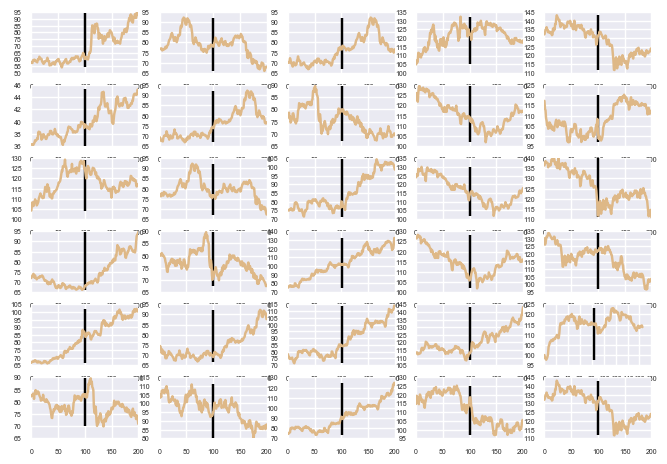

In [56]:
num_cols = 5
num_rows = 6
f, axarr = plt.subplots(num_rows, num_cols)
ith_period = 0

for col in range(0, num_cols):
    for row in range(0, num_rows):
        axarr[row, col].tick_params(labelsize=5)
        if ith_period >= len(evt_windows):
            continue
        x1 = []
        x1.extend(est_windows[ith_period])
        x1.append(prices_arr[indices[ith_period]])
        x1.extend(evt_windows[ith_period])
        axarr[row, col].plot(x1, c='burlywood')
        axarr[row, col].vlines(x=len(x1)/2, ymin=min(x1), ymax=max(x1))
        ith_period += 1
plt.show()

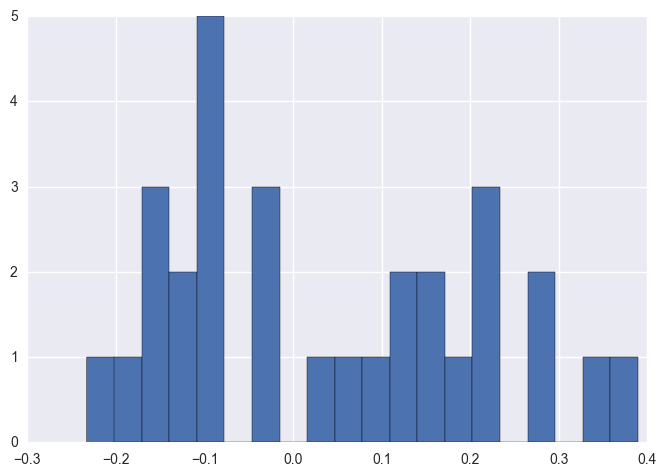

In [57]:
plt.hist(car, bins=20)
plt.show()

In [58]:
len(car)

30

In [83]:
car_series = pd.Series(car, index=recalls_by_unit_after_1995_unique.index.values)

In [86]:
#car_series

In [ ]:
#I'll examine what kind of recalls these were

In [71]:
indices_of_important_recalls = set(recalls_by_unit_after_1995_unique.index.values)

In [79]:
len(recalls_by_unit_after_1995_unique)

30

In [85]:
recalls_by_unit_after_1995_unique

,Estimated Units,Recall Notification Date
9086,540037.0,1999-11-30
28887,627858.0,1996-05-08
32424,533124.0,2007-02-28
41204,768379.0,2005-07-05
61620,977839.0,2005-10-05
68035,4445056.0,2009-12-31
68410,769379.0,2011-05-06
70942,728544.0,2010-11-15
70958,1363244.0,2011-04-13
73357,2230661.0,2010-02-05


In [91]:
full_description_df = toyota_df_over_500k.loc[indices_of_important_recalls]
full_description_df['car_value'] = car_series
full_description_df.to_csv("toyota_recalls.csv")